<div style="font-family: 'Palatino';">

**Author:** Ludvig Holm  
**Date:** May 4th, 2024  

---

# Analysing the impact of a Battery Energy Storage System (BESS) on the Villagetown Power Grid

---
</div>

<div style="font-family: 'Palatino';">

## Import libraries
</div>

In [100]:
from matplotlib.font_manager import FontProperties
from IPython.display import set_matplotlib_formats
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import stats
import seaborn as sns
import pandas as pd

<div style="font-family: 'Palatino';">

## Setup visual settings
</div>

In [101]:
# Increase dpi
set_matplotlib_formats('retina')

# Setup Seaborn
sns.set_context("talk")
sns.set_style("whitegrid")

# Define exact color codes for consistency
dark_blue = "#00008B"
dark_green = "#006400"
dark_red = "#8B0000"

<div style="font-family: 'Palatino';">

## Data pre-processing
</div>

In [102]:
# Load the data from the CSV file
file_path = "Data/villagetown-data-.csv"
data = pd.read_csv(file_path)

# Parse datetime
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

# Adding the battery operation to the grid load to simulate grid load with BESS
data['adjusted_grid_load'] = data['grid_load'] + data['battery_operation']

<div style="font-family: 'Palatino';">

## Battery Operation Analysis
This visual depiction showcases the battery's behavior during the initial week.

The data indicates a pattern of incremental increases in battery activity, indicative of step charging. This method involves adjusting voltage and current gradually to optimize battery health and efficiency while reducing thermal and electrical stresses, thus extending its lifespan.
</div>

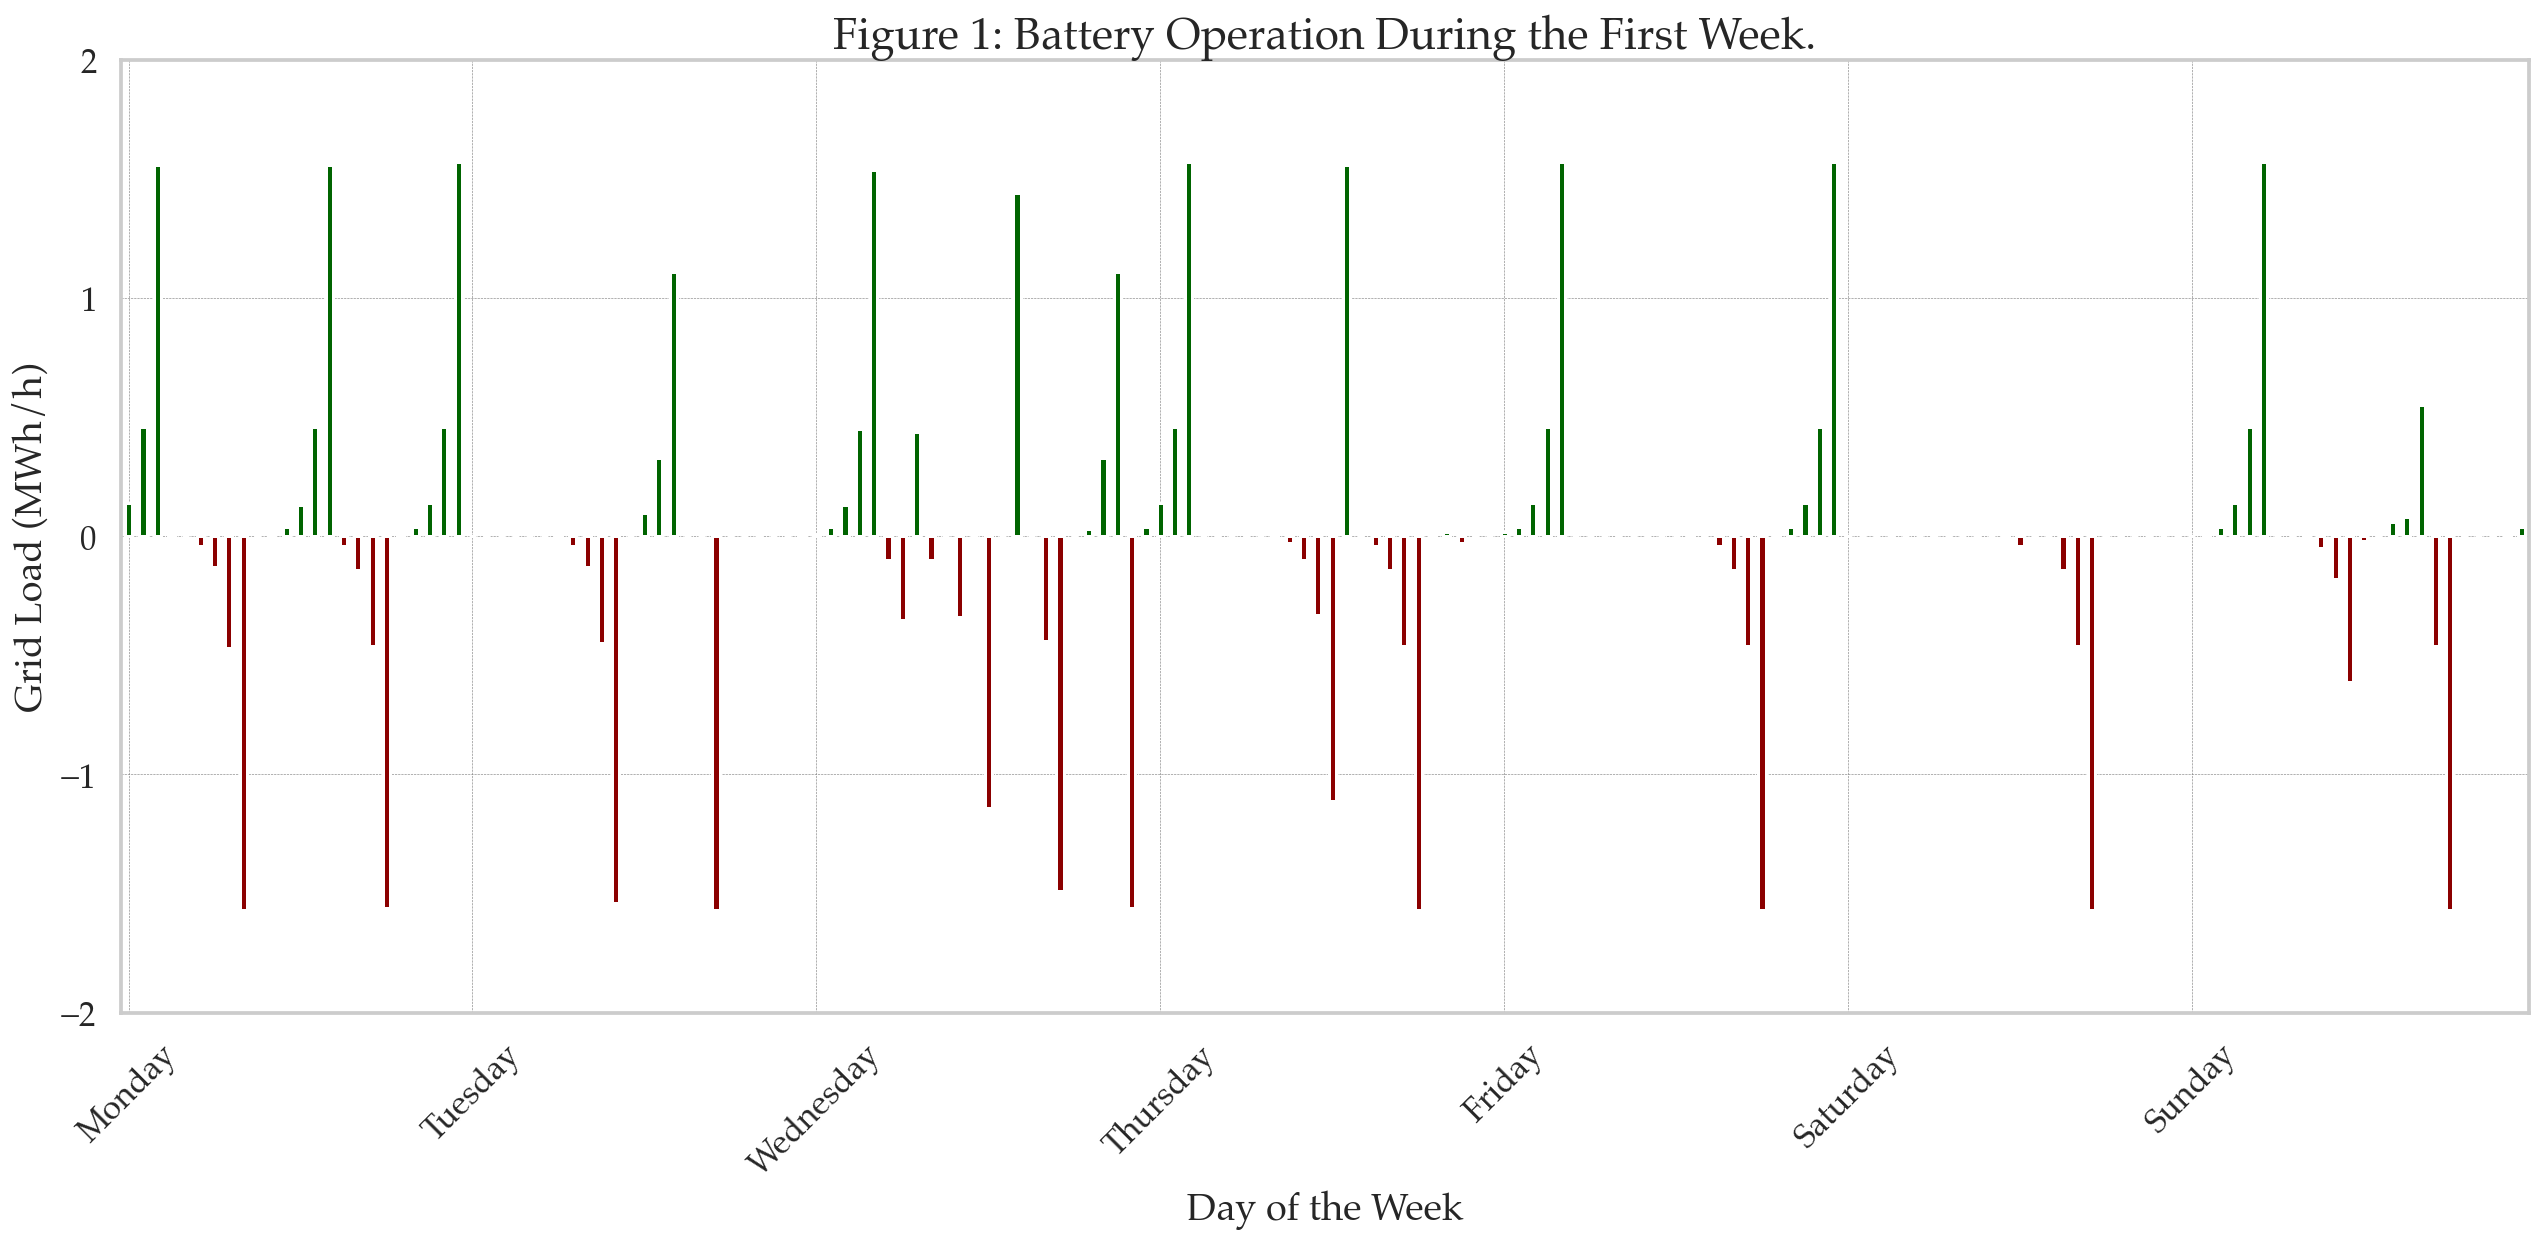

In [103]:
# Extract data for the first week (start on first Monday)
w1_data = data.head(24 * 9).tail(24 * 7)

# Create a list of day names based on the date index for labeling the x-axis
day_of_week_labels = w1_data.index.to_series().dt.day_name().unique()

# Set the font to Palatino (LaTeX)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Palatino',
    'font.size': 18
})

# Plot
plt.figure(figsize=(18, 9))
colors = ['darkred' if x < 0 else 'darkgreen' for x in w1_data['battery_operation']]
w1_data['battery_operation'].plot(kind='bar', color=colors)
plt.title('Figure 1: Battery Operation During the First Week.', fontdict={'fontsize': 22, 'fontweight': 'bold'})
plt.xlabel('Day of the Week', fontdict={'fontsize': 19, 'fontweight': 'bold'})
plt.ylabel('Grid Load (MWh/h)', fontdict={'fontsize': 19, 'fontweight': 'bold'})
plt.xticks(ticks=[i * 24 for i in range(7)], labels=day_of_week_labels, rotation=45)
plt.yticks(range(int(min(w1_data['battery_operation']) - 1), int(max(w1_data['battery_operation']) + 2)))
plt.grid(True, linestyle='--', linewidth=0.3, color='gray')
plt.tight_layout()
plt.show()

<div style="font-family: 'Palatino';">G

## Comparative Visualization of Grid Load: With and Without BESS
In scenarios without the BESS, the maximum import capacity is never exceeded, whereas with the BESS, this threshold is surpassed six times. These six occurrences represent only approximately 0.068% of the year, calculated as $\frac{6}{24 \times 365}$. This indicates that the grid company can deliver electricity to their customers for over 99.9% of the hours throughout the year, maintaining a highly reliable service.
</div>

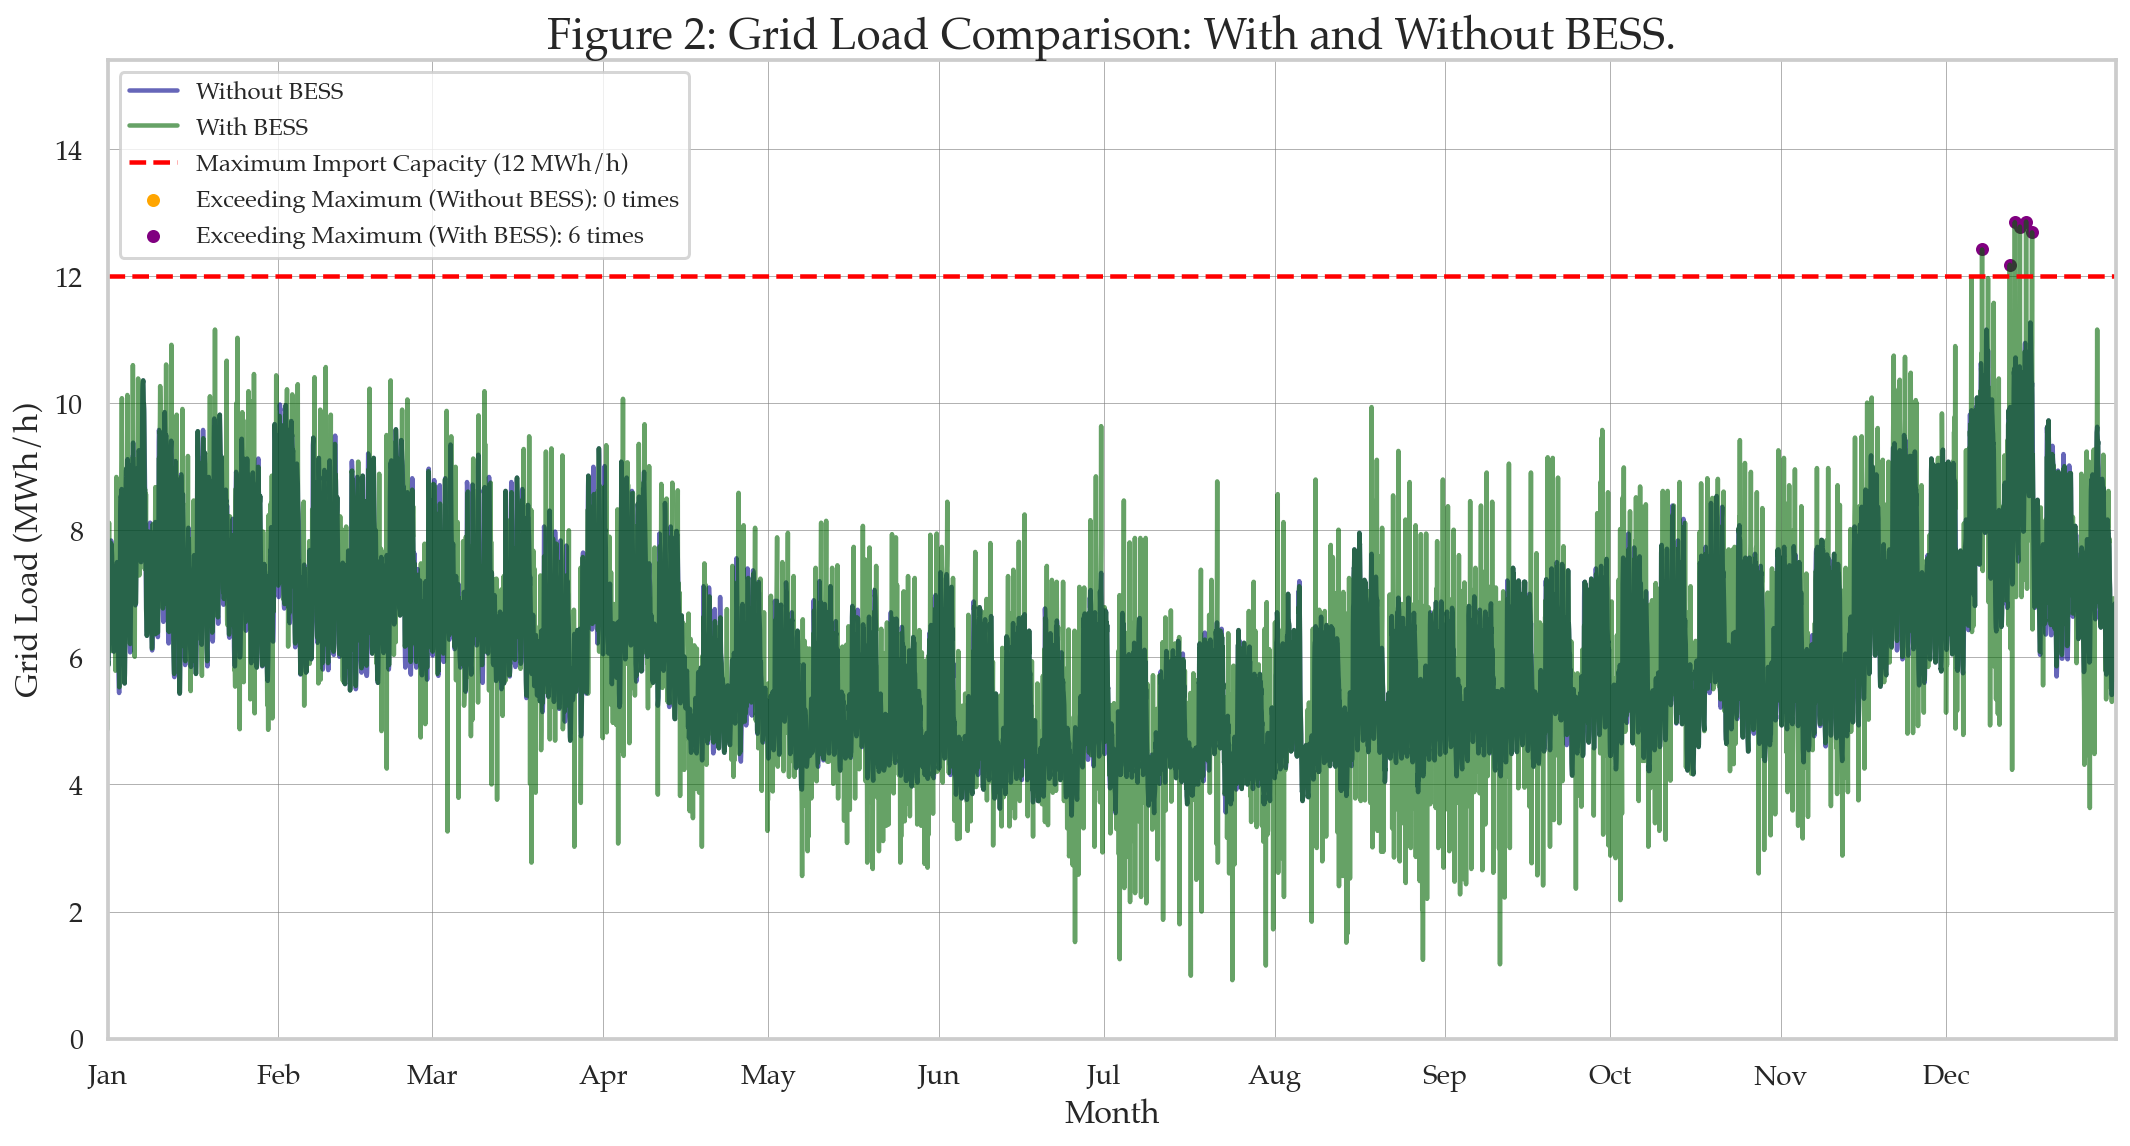

In [104]:
# Calculate if the grid and adjusted loads exceed the import and export limits
data['grid_import_exceeded'] = data['grid_load'] > 12
data['adjusted_import_exceeded'] = data['adjusted_grid_load'] > 12

# Count exceedances
num_grid_import_exceeded = data['grid_import_exceeded'].sum()
num_adjusted_import_exceeded = data['adjusted_import_exceeded'].sum()

# Generate monthly tick labels
month_starts = pd.date_range(start=data.index.min(), end=data.index.max(), freq='MS')

# Plotting 'Grid Load without BESS' and 'Grid Load with BESS' for comparison using Seaborn and Matplotlib
plt.figure(figsize=(18, 9))
sns.lineplot(data=data, x=data.index, y='grid_load', label='Without BESS', color=dark_blue, alpha=0.6)
sns.lineplot(data=data, x=data.index, y='adjusted_grid_load', label='With BESS', color=dark_green, alpha=0.6)
plt.axhline(y=12, color='red', linestyle='--', label='Maximum Import Capacity (12 MWh/h)')
plt.scatter(data.index[data['grid_import_exceeded']], data['grid_load'][data['grid_import_exceeded']],
            color='orange', label=f'Exceeding Maximum (Without BESS): {num_grid_import_exceeded} times', s=25)
plt.scatter(data.index[data['adjusted_import_exceeded']], data['adjusted_grid_load'][data['adjusted_import_exceeded']],
            color='purple', label=f'Exceeding Maximum (With BESS): {num_adjusted_import_exceeded} times', s=25)
plt.title('Figure 2: Grid Load Comparison: With and Without BESS.', fontdict={'fontsize': 22, 'fontweight': 'bold'})
plt.xlabel('Month', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel('Grid Load (MWh/h)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.legend(loc='upper left', fontsize=12)
plt.xticks(month_starts, month_starts.strftime('%b'), fontdict={'fontsize': 14})
plt.yticks(fontsize=14)
plt.xlim(data.index.min(), data.index.max())
plt.ylim(0, 15.4)
plt.grid(True, which='both', linestyle='-', linewidth=0.3, color='gray')
plt.show()

<div style="font-family: 'Palatino';">

## Statistical Evaluation of Load Management

### Load Redistribution: Peak vs. Non-Peak Hours
The implementation of a BESS facilitates a redistribution of 0.4% of the total grid load from peak to non-peak hours. This strategic shift not only optimizes load management but also contributes to cost savings by leveraging lower energy prices during off-peak periods.
</div>

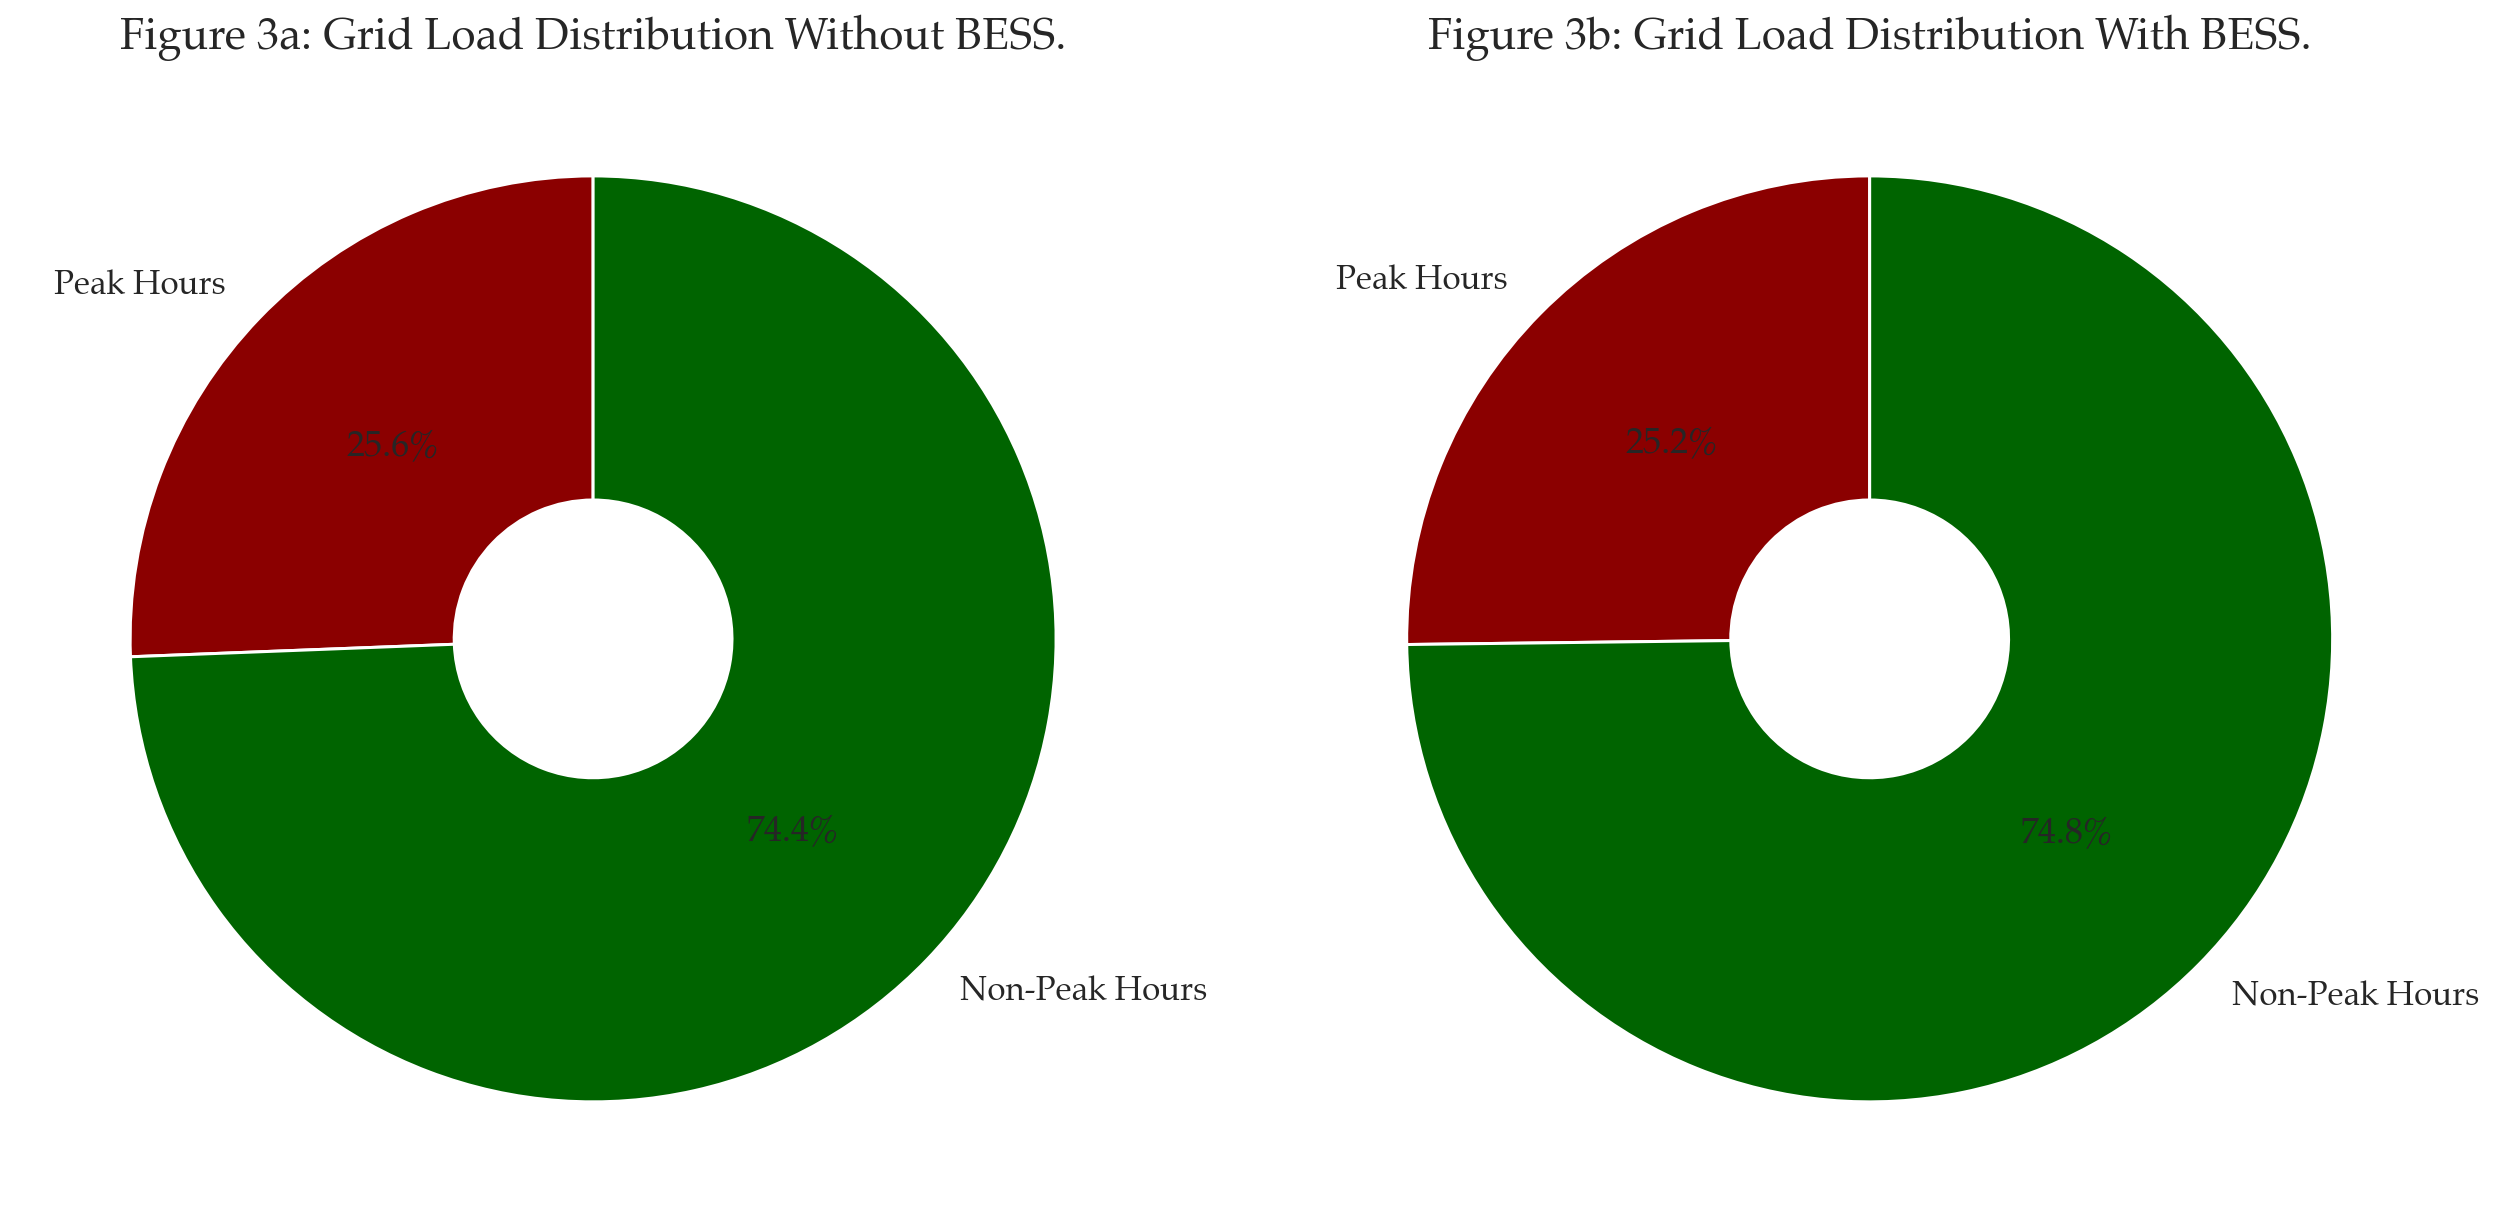

In [105]:
# Configure matplotlib to use Palatino font
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Palatino',
    'font.size': 18
})

# Calculate total load during peak and non-peak hours, with and without BESS
data['total_load_without_bess'] = data.groupby(['peak'])['grid_load'].transform('sum')
data['total_load_with_bess'] = data.groupby(['peak'])['adjusted_grid_load'].transform('sum')

# Prepare data for plotting
load_distribution_without_bess = [data.loc[data['peak'] == 1, 'total_load_without_bess'].iloc[0],
                                  data.loc[data['peak'] == 0, 'total_load_without_bess'].iloc[0]]
load_distribution_with_bess = [data.loc[data['peak'] == 1, 'total_load_with_bess'].iloc[0], 
                               data.loc[data['peak'] == 0, 'total_load_with_bess'].iloc[0]]

# Set up the plot with donut charts for visualization
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
labels = ['Peak Hours', 'Non-Peak Hours']
colors = [dark_red, dark_green]

# Donut chart for Grid Load Without BESS
axes[0].pie(load_distribution_without_bess, labels=labels, autopct='%1.1f%%', startangle=90,
            colors=colors, wedgeprops={'width': 0.7})
axes[0].set_title('Figure 3a: Grid Load Distribution Without BESS.', fontdict={'fontsize': 22, 'fontweight': 'bold'})

# Donut chart for Grid Load With BESS
axes[1].pie(load_distribution_with_bess, labels=labels, autopct='%1.1f%%', startangle=90,
            colors=colors, wedgeprops={'width': 0.7})
axes[1].set_title('Figure 3b: Grid Load Distribution With BESS.', fontdict={'fontsize': 22, 'fontweight': 'bold'})

plt.tight_layout()
plt.show()

<div style="font-family: 'Palatino';">

## Distribution Analysis
### Histogram and Kernel Density Estimate (KDE) Observations
The KDE curve's smoothness in the plot featuring BESS operation indicates a more even distribution of grid load levels, in contrast to the plot without BESS, where sharper peaks suggest more frequent abrupt load changes. This comparative smoothness signifies a steadier and more continuous range of load variations, rather than discrete, sudden shifts to high-load states.

Such smoothness in the KDE curve is indicative of the BESS's effectiveness in modulating and smoothing out grid loads. This functionality plays a crucial role in mitigating the frequency and impact of sudden load surges, thereby enhancing grid reliability and reducing the potential for service disruptions or infrastructure stress.
</div>

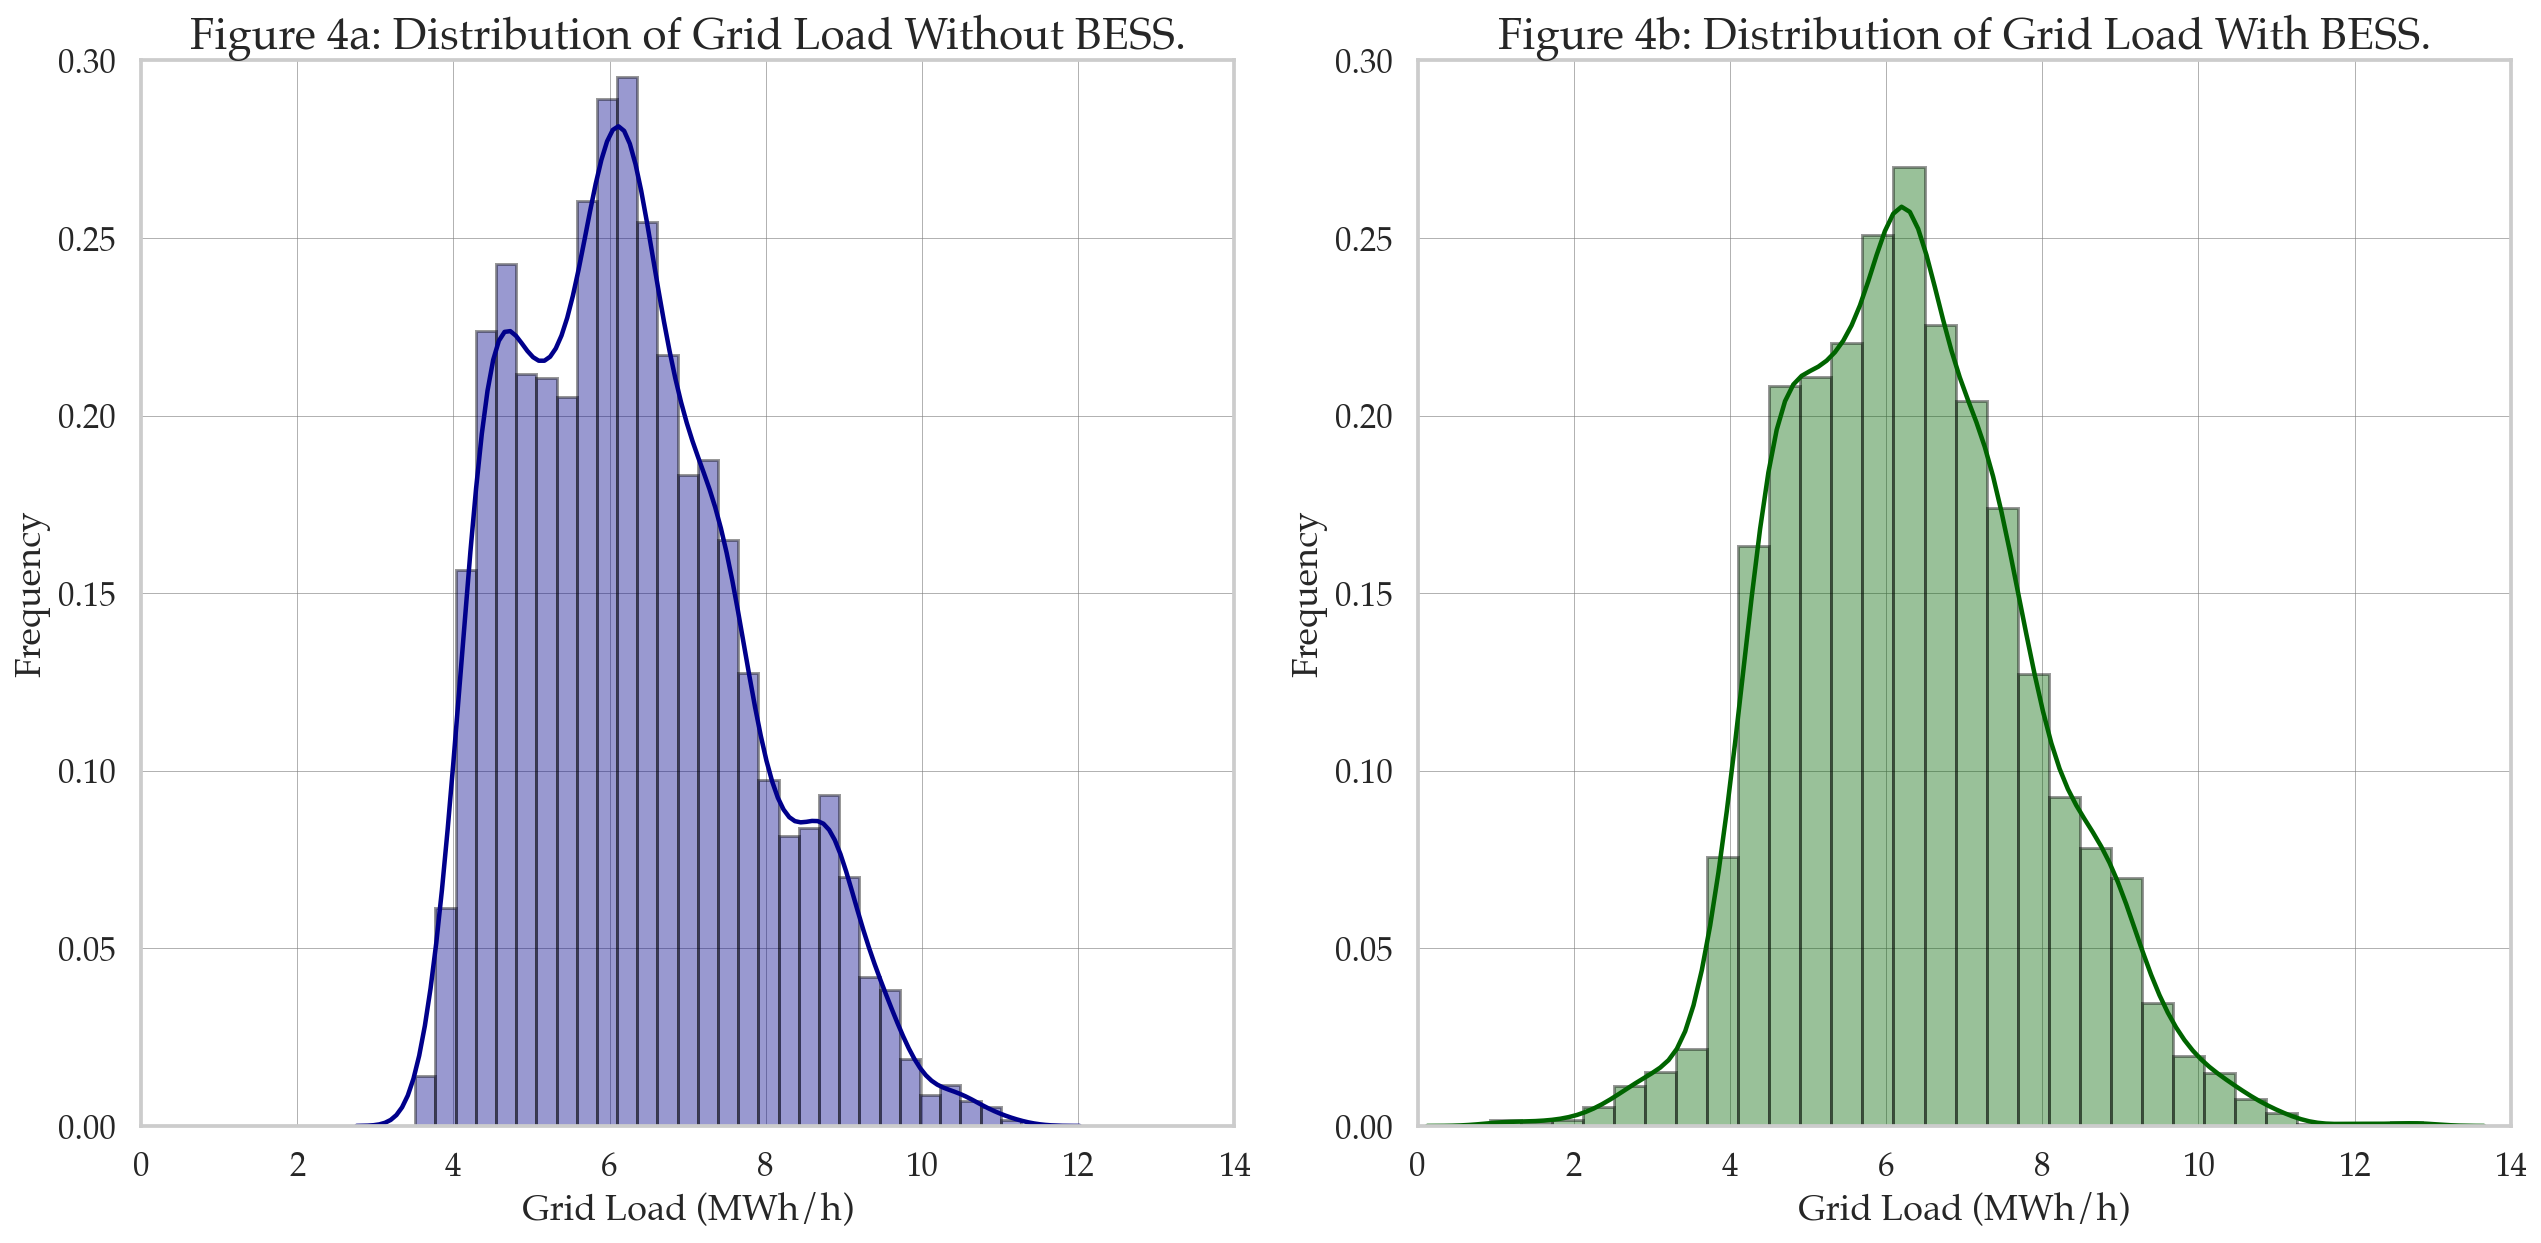

In [106]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 9))

# Plot a histogram and kernel density estimate for grid load without BESS using distplot
plt.subplot(1, 2, 1)
sns.distplot(data['grid_load'], bins=30, kde=True, color=dark_blue, hist_kws={'edgecolor':'black'})
plt.title('Figure 4a: Distribution of Grid Load Without BESS.', fontdict={'fontsize': 22, 'fontweight': 'bold'})
plt.xlabel('Grid Load (MWh/h)', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.ylabel('Frequency', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.xlim(0, 14)
plt.ylim(0, 0.30)
plt.grid(True, which='both', linestyle='-', linewidth=0.3, color='gray')

# Plot a histogram and kernel density estimate for grid load with BESS using distplot
plt.subplot(1, 2, 2)
sns.distplot(data['adjusted_grid_load'], bins=30, kde=True, color=dark_green, hist_kws={'edgecolor':'black'})
plt.title('Figure 4b: Distribution of Grid Load With BESS.', fontdict={'fontsize': 22, 'fontweight': 'bold'})
plt.xlabel('Grid Load (MWh/h)', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.ylabel('Frequency', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.xlim(0, 14)
plt.ylim(0, 0.30)
plt.grid(True, which='both', linestyle='-', linewidth=0.3, color='gray')
plt.tight_layout()
plt.show()

<div style="font-family: 'Palatino';">

### Analysis of Box Plots and Violin Plots
In the box plots, both the median and the interquartile range (IQR), which represents the middle 50% of the data, appear quite similar. However, the presence of outliers at both the high and low ends of the grid load spectrum in the scenarios with BESS indicates an increased variability in operating conditions.

The violin plots further elaborate on this analysis by illustrating the smoothness of the distribution curve when BESS is implemented. This smooth contour of the BESS violin plot underscores the system's effectiveness in stabilizing grid operations.
</div>

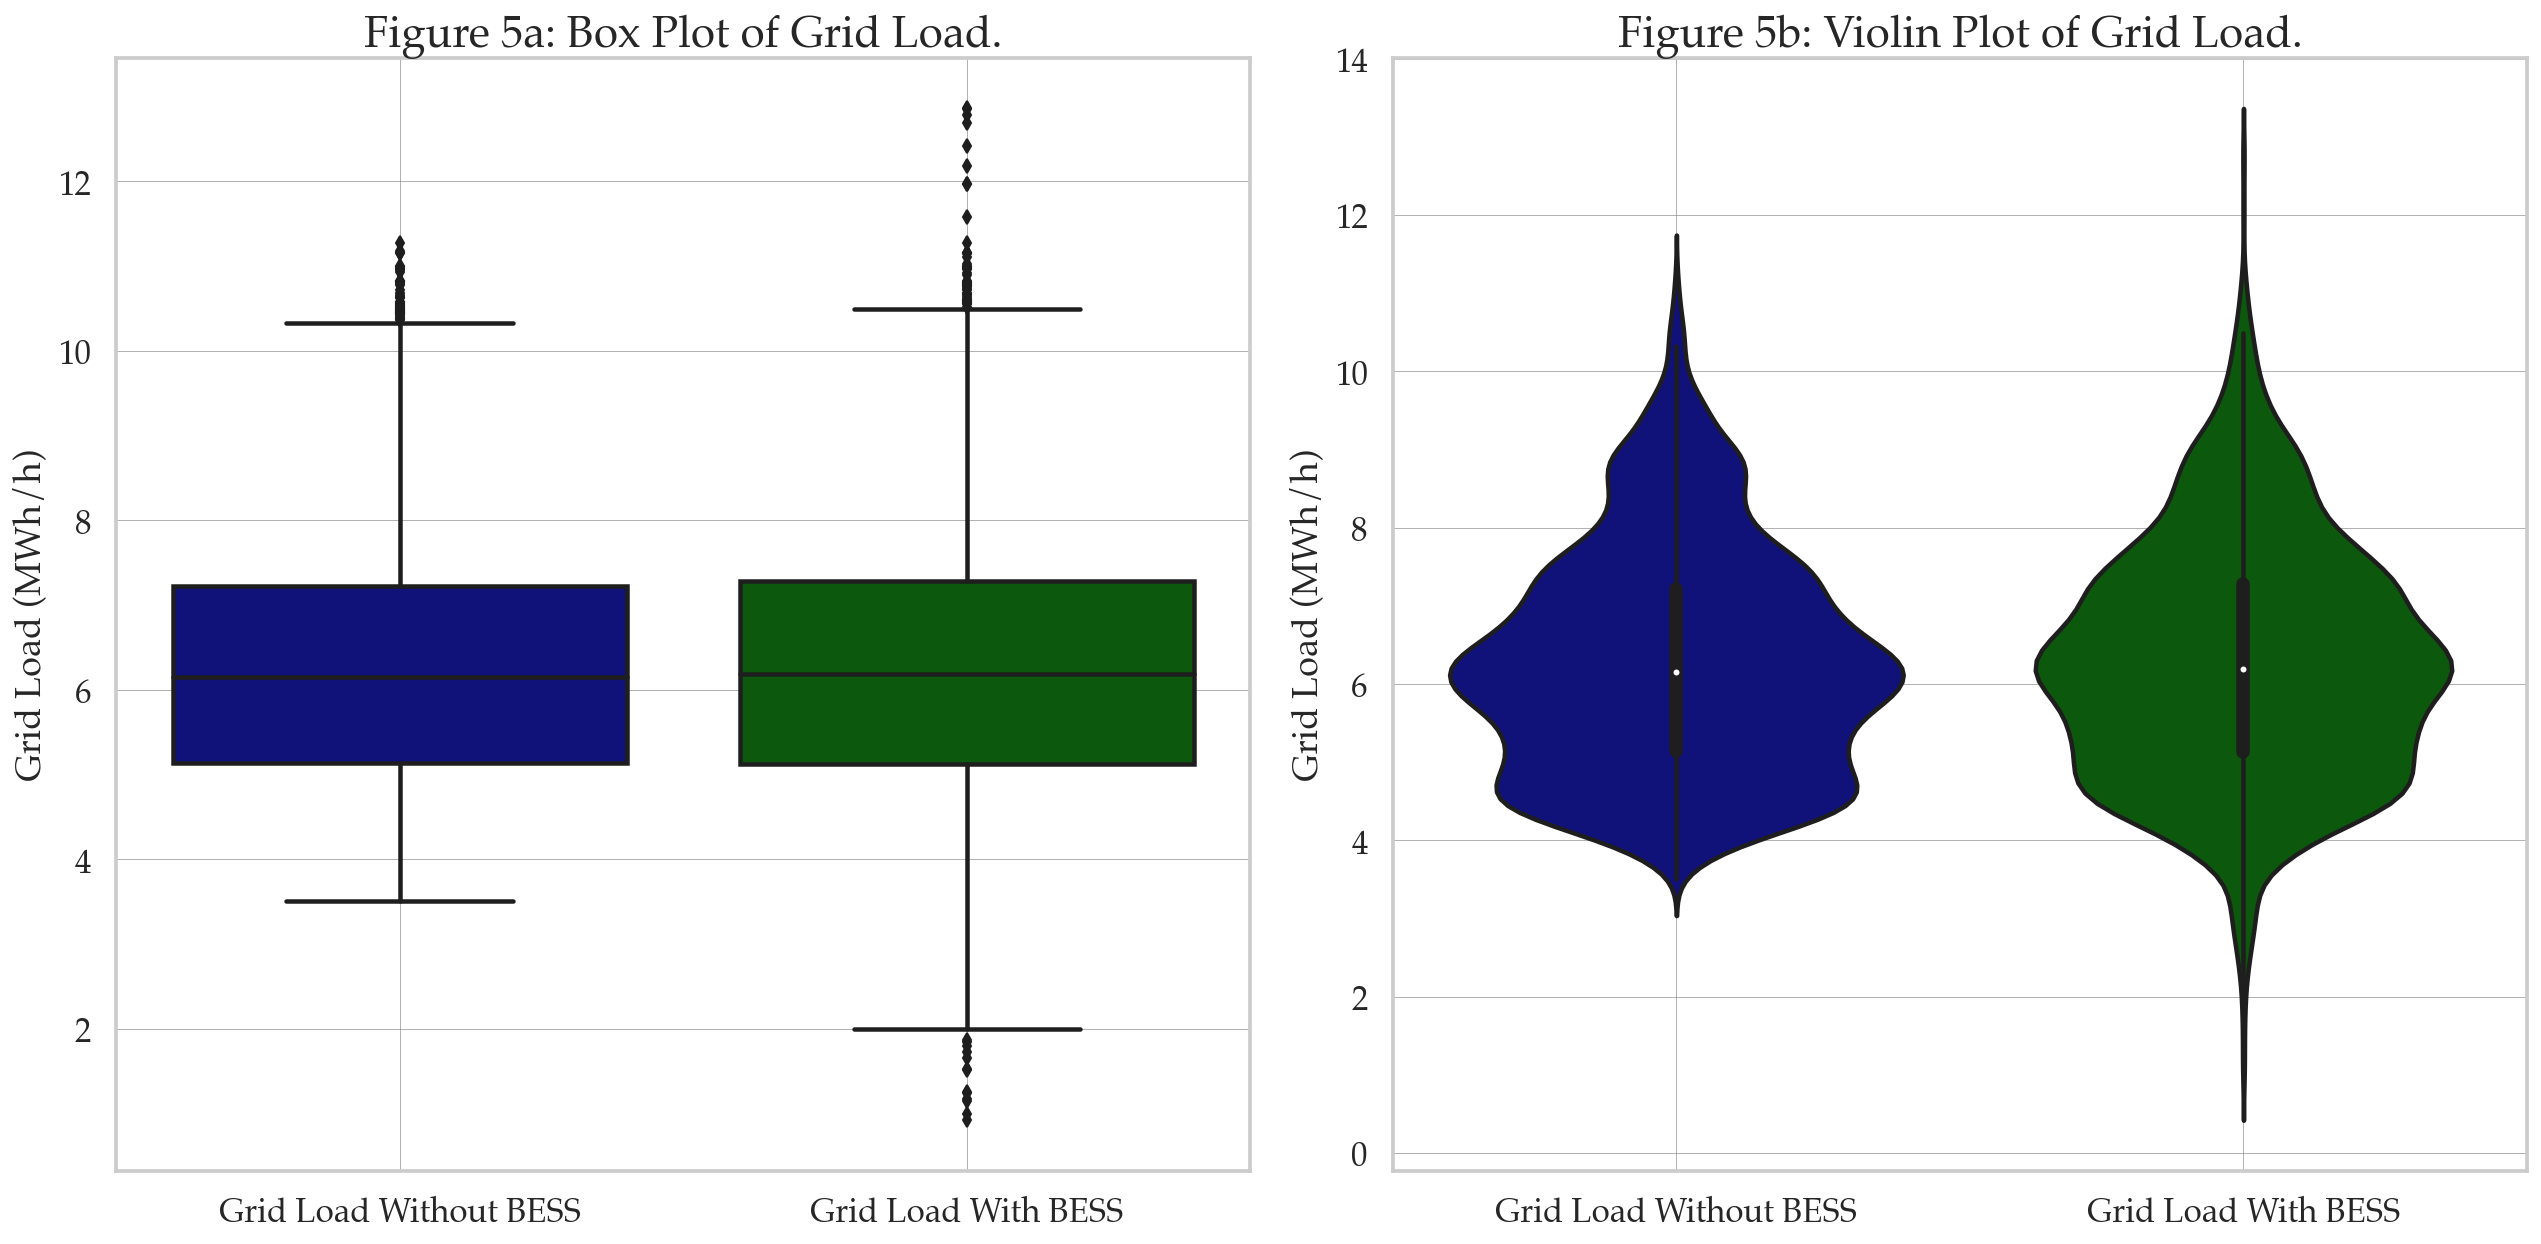

In [107]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 9))

# Create a DataFrame for easier plotting
df_plot = pd.DataFrame({
    'Grid Load Without BESS': data['grid_load'],
    'Grid Load With BESS': data['adjusted_grid_load']
})

# Define custom colors for the plots
custom_palette = [dark_blue, dark_green]

# Plotting box plots
plt.subplot(1, 2, 1)
sns.boxplot(data=df_plot, palette=custom_palette)
plt.title('Figure 5a: Box Plot of Grid Load.', fontdict={'fontsize': 22, 'fontweight': 'bold'})
plt.ylabel('Grid Load (MWh/h)', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.grid(True, which='both', linestyle='-', linewidth=0.3, color='gray')

# Plotting violin plots
plt.subplot(1, 2, 2)
sns.violinplot(data=df_plot, palette=custom_palette)
plt.title('Figure 5b: Violin Plot of Grid Load.', fontdict={'fontsize': 22, 'fontweight': 'bold'})
plt.ylabel('Grid Load (MWh/h)', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.grid(True, which='both', linestyle='-', linewidth=0.3, color='gray')
plt.tight_layout()
plt.show()


<div style="font-family: 'Palatino';">

### Descriptive Statistics Insights
#### Skewness Analysis
- **Skewness Without BESS:** 0.514
- **Skewness With BESS:** 0.331
  - The reduction in skewness from 0.514 to 0.331 with the implementation of BESS highlights its effectiveness in moderating grid load fluctuations. This smoother distribution aids in providing a more stable and reliable power supply. Such statistical evidence supports the broader integration of battery storage systems in grid management, particularly valuable in environments with high demand variability or a growing proportion of intermittent renewable energy sources.

#### Kurtosis Analysis
- **Kurtosis Without BESS:** -0.264
- **Kurtosis With BESS:** 0.067
  - The shift in kurtosis towards a more Gaussian distribution underscores the BESS's role in normalizing grid load distributions. This shift not only enhances operational reliability but also improves the economic efficiency of managing the grid, pointing to a beneficial stabilization effect from BESS integration.

#### Statistical Test Results
- **T-test p-value:** Insignificant results.
  - This suggests that, statistically, mean grid loads before and after BESS implementation do not differ significantly, which may indicate consistent performance under varying conditions.
- **Kolmogorov-Smirnov test p-value:** Statistically significant change.
  - The significant p-value indicates a noteworthy change in the distribution of grid loads due to BESS. This highlights BESS's impact in altering load dynamics, even though the KS-statistic's absolute difference isn't extensive, it's statistically meaningful.
</div>

In [108]:
# Calculate Skewness and Kurtosis for grid load with and without BESS
skewness_without_bess = data['grid_load'].skew()
skewness_with_bess = data['adjusted_grid_load'].skew()
kurtosis_without_bess = data['grid_load'].kurt()
kurtosis_with_bess = data['adjusted_grid_load'].kurt()

# Display Skewness and Kurtosis results
print("Skewness and Kurtosis Analysis:")
print(f"\tSkewness Without BESS:\t {skewness_without_bess:.3f}")
print(f"\tSkewness With BESS:\t {skewness_with_bess:.3f}")
print(f"\tKurtosis Without BESS:\t {kurtosis_without_bess:.3f}")
print(f"\tKurtosis With BESS:\t {kurtosis_with_bess:.3f}\n")

# Perform the T-test for independent samples assuming unequal variances
t_stat, p_value_t = stats.ttest_ind(data['grid_load'], data['adjusted_grid_load'], equal_var=False)

# Perform Kolmogorov-Smirnov test for distribution comparison
ks_stat, p_value_ks = stats.ks_2samp(data['grid_load'], data['adjusted_grid_load'])

# Display T-test and Kolmogorov-Smirnov test results
print("Statistical Test Results:")
print(f"\tT-test p-value:\t\t\t   {p_value_t:.3f} (T-statistic: {t_stat:.3f})")
print(f"\tKolmogorov-Smirnov test p-value:   {p_value_ks:.3f} (KS-statistic: {ks_stat:.3f})")

Skewness and Kurtosis Analysis:
	Skewness Without BESS:	 0.514
	Skewness With BESS:	 0.331
	Kurtosis Without BESS:	 -0.264
	Kurtosis With BESS:	 0.067

Statistical Test Results:
	T-test p-value:			   0.998 (T-statistic: 0.002)
	Kolmogorov-Smirnov test p-value:   0.005 (KS-statistic: 0.026)
